# 次の月の接続数を求める

In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
# 訓練用データ(train)テスト用データ(test)を分ける　train_test_split
# k分割交差検証を行うKFoldをインストール
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks


In [2]:
# データの読み込み

# データセットのパス
file_path = "dataset/csgo_graf2.csv"
# データを入れる配列変数
datas = list()
# ファイルの読み込み
with open(file_path, "r") as f:
    
    r = csv.reader(f)  # rに読み込んだcsvを入れている

    # 読み込んだデータセットをitemsに読み込んでいる
    # next関数では１行目の要素名の読み込みをしない様にできる
    # イテレータ(iter)は要素を一つずつ取り出せる

    items = next(iter(r)) #itemsの0行目に要素名を入れている
    items[0] = items[0][1:] 

    # rはデータ数　Rはデータ数分を繰り返す
    # データを一月分ずらすことで、次の月を出している
    for i, R in enumerate(r):
        if i == 0: 
            tmp = float(R[8])
            continue
            
        # datasに各要素の内容である数値を入れている
        datas.append({
            I:V for I, V in zip(items, map(float, R))
        })
        datas[-1]["avg"] = tmp
        tmp = float(R[8])
        

datas, len(datas)

([{'year': 2022.0,
   'month': 11.0,
   'date': 202211.0,
   'good': 55857.0,
   'bad': 6644.0,
   'all_review_count': 62501.0,
   'recommend_count': 5.0,
   'review_count': 6.0,
   'avg': 629325.0,
   'gain': 12656.5,
   'peak': 1129095.0,
   'price': 0.0,
   'steam_online': 852068535.0},
  {'year': 2022.0,
   'month': 10.0,
   'date': 202210.0,
   'good': 55731.0,
   'bad': 6675.0,
   'all_review_count': 62406.0,
   'recommend_count': 6.0,
   'review_count': 6.0,
   'avg': 621006.0,
   'gain': -10426.5,
   'peak': 1078860.0,
   'price': 0.0,
   'steam_online': 849997689.0},
  {'year': 2022.0,
   'month': 9.0,
   'date': 202209.0,
   'good': 57430.0,
   'bad': 7128.0,
   'all_review_count': 64558.0,
   'recommend_count': 4.0,
   'review_count': 4.0,
   'avg': 608349.5,
   'gain': -22668.7,
   'peak': 1100366.0,
   'price': 0.0,
   'steam_online': 798181709.0},
  {'year': 2022.0,
   'month': 8.0,
   'date': 202208.0,
   'good': 71809.0,
   'bad': 9490.0,
   'all_review_count': 81299.0,

In [3]:
# データの標準化

# データの平均
mean_items = {
    I: np.average([D[I] for D in datas])  for I in items
}
# データの標準偏差
std_items = {
    I: np.std([D[I] for D in datas])  for I in items
}
# データの標準化
standardization_datas = [
    {I:(D[I] - mean_items[I]) / std_items[I] for I in items} for D in datas
]

mean_items, std_items, standardization_datas

({'year': 2017.96261682243,
  'month': 6.4485981308411215,
  'date': 201802.71028037384,
  'good': 57033.53271028037,
  'bad': 7636.1682242990655,
  'all_review_count': 64669.700934579436,
  'recommend_count': 3.9158878504672896,
  'review_count': 4.411214953271028,
  'avg': 418133.41570093454,
  'gain': 5366.5222429906535,
  'peak': 715313.0,
  'price': 565.7663551401869,
  'steam_online': 482132167.1214953},
 {'year': 2.564769336679463,
  'month': 3.426760124468988,
  'date': 256.4189041008779,
  'good': 33251.4001875988,
  'bad': 4951.444306398299,
  'all_review_count': 37215.10212999656,
  'recommend_count': 2.226104662573369,
  'review_count': 2.590252291786169,
  'avg': 173012.8872184669,
  'gain': 37362.302464107546,
  'peak': 265331.46595278557,
  'price': 654.3025762580565,
  'steam_online': 198253770.00640947},
 [{'year': 1.5741700900078421,
   'month': 1.3281938927266366,
   'date': 1.592276205445198,
   'good': -0.035382952406291815,
   'bad': -0.2003795585496089,
   'all_r

In [4]:
# データ作成
max_year, min_year = int(max([D["year"] for D in datas])), int(min([D["year"] for D in datas]))

# 目的変数と説明変数
x = list()
y = list()

# DはデータDSは標準化したデータ
for D, SD in zip(datas, standardization_datas):
    tmp = list()
    
    # Iには要素名
    for I in items:
        # yearの要素をone-hot表現にしている
        if I == "year":
            # 年の数だけ0を入力
            a = [0] * (max_year - min_year + 1)
            # 
            a[int(D["year"]) - min_year] = 1
            tmp += a
        # 月ごとのone-hot表現
        elif I == "month":
            a = [0] * 12  #分割する数をかけてあげる
            a[int(D["month"]) - 1] = 1 #分割の時の一番低い数を引いてあげる
            tmp += a
        # dateは省く様にしている
        elif I == "date":
            continue

        # 教師信号なのでyに入れる
        elif I == "avg":
            y.append(SD[I])

        else:
            tmp.append(SD[I])
        
    x.append(tmp)

# print(x)
x = np.array(x, np.float32)
y = np.array(y, np.float32)
print(len(x[0]))

# 学習データ/テストデータ分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# for xtr, xte, ytr, yte in zip(x_train, x_test, y_train, y_test):
#     print(f"xtr{xtr} xte{xte} ytr{ytr} yte{yte}")
print(x_test)


30
[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00 -2.8562805e-01 -6.5459049e-01 -3.4229922e-01
  -1.7590762e+00 -1.7030059e+00 -1.9288780e-01  2.6907477e-01
   2.6628911e-01 -8.5670382e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  6.4906943e-01  4.4953182e-01  6.3974833e-01
  -1.3098611e+00 -1.3169432e+00  1.3488349e+00  1.0413842e+00
  -8.6468613e-01  1.8129492e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
 

In [5]:
# モデル生成
# input_dimには入力の値を入れる

activation = "tanh"

"""
model = models.Sequential()
model.add(layers.Input(shape=x_train.shape[1:]))
model.add(layers.Dense(512, activation= activation))
# model.add(layers.LayerNormalization())
model.add(layers.Dense(256, input_dim=5, activation= activation))
model.add(layers.Dense(128, input_dim=5, activation= activation))
model.add(layers.Dense(64, input_dim=5, activation= activation))
# model.add(layers.Dense(32, input_dim=5, activation= activation))
model.add(layers.Dense(16, activation= activation))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
"""

# nnの構成をする関数
def build_model(x):
    # 活性化関数
    activation = "tanh"
    activation2 = "relu"

    # 入力層
    # inputするのは、12の要素
    input = layers.Input(shape = x.shape[1:])
    
    # 中間層
    # Denseは全結合で,(ニューロン数, 活性化関数)(入力やその後に出た計算xを再度入力)
    x = layers.Dense(units = 512, activation = activation)(input)
    x = layers.Dense(units = 256, activation = activation)(x)
    x = layers.Dense(units = 128, activation = activation)(x)
    x = layers.Dense(units = 64, activation = activation)(x)
    # x = layers.Dense(units = 32, activation = activation)(x)
    # x = layers.Dense(units = 16, activation = activation)(x)
    # x = layers.Dense(units = 8, activation = activation)(x)

    # 出力層
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model(x)
model.summary()

model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.00001))

mc = callbacks.ModelCheckpoint(
    filepath = "model.h5",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min"
)

history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 500, verbose = 1, 
                    validation_data=(x_test, y_test), callbacks =[mc])


print(model.evaluate(x_test, y_test))
model = models.load_model("model.h5")
print(model.evaluate(x_test, y_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 512)               15872     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 188,417
Trainable params: 188,417
Non-trainable

2023-10-16 10:36:26.260791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 645ms/step - loss: 0.8936 - val_loss: 1.0503
Epoch 2/500
1/1 [==============================] - 0s 47ms/step - loss: 0.8676 - val_loss: 1.0195
Epoch 3/500
1/1 [==============================] - 0s 47ms/step - loss: 0.8421 - val_loss: 0.9893
Epoch 4/500
1/1 [==============================] - 0s 55ms/step - loss: 0.8171 - val_loss: 0.9597
Epoch 5/500
1/1 [==============================] - 0s 56ms/step - loss: 0.7926 - val_loss: 0.9307
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 0.7687 - val_loss: 0.9022
Epoch 7/500
1/1 [==============================] - 0s 52ms/step - loss: 0.7452 - val_loss: 0.8743
Epoch 8/500
1/1 [==============================] - 0s 48ms/step - loss: 0.7223 - val_loss: 0.8471
Epoch 9/500
1/1 [==============================] - 0s 53ms/step - loss: 0.6999 - val_loss: 0.8204
Epoch 10/500
1/1 [==============================] - 0s 56ms/step - loss: 0.6781 - val_loss: 0.7944
Epoch 11/500
1/1 [============

In [6]:
# 学習モデルの動き testを分割しているので11コのavg予測が出ている　また12月のリストを見てあっているのかを誤差を出して確認している
predict = model.predict(x_test)
print(len(x_test))
for X, Y in zip(predict, y_test):
    print("y = ", X)

print("")
for X, Y in zip(predict, y_test):
    print("誤差")
    print(X - Y)


# print(predict-y_test)
# print("y_test=", y_test)

1/1 [==============================] - 0s 88ms/step
11
y =  [-0.31788006]
y =  [1.106058]
y =  [-0.67295647]
y =  [1.117575]
y =  [1.6567612]
y =  [-1.4657086]
y =  [-1.9775177]
y =  [1.0192918]
y =  [0.56892484]
y =  [-0.46963412]
y =  [-0.33235723]

誤差
[-0.08271663]
誤差
[-0.14532268]
誤差
[-0.12035298]
誤差
[0.01814198]
誤差
[-0.07530832]
誤差
[0.19369805]
誤差
[0.0936693]
誤差
[0.1706366]
誤差
[0.0259099]
誤差
[-0.14961562]
誤差
[-0.18245958]


In [14]:
adam_history = history

In [7]:
sigmoid_history = history

In [9]:
relu_history = history

Text(0.5, 0, 'epochs')

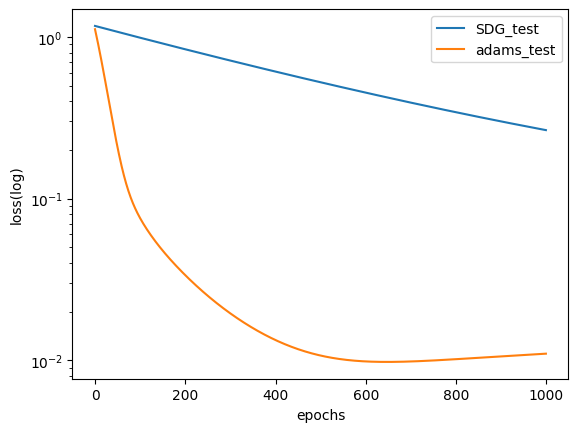

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
# 学習曲線
# ax.plot(history.history["loss"], label = "train")
# 活性化関数tanhで学習した後のtanh_test
# ax.plot(history.history["val_loss"], label = "tanh_test")
# ax.plot(relu_history.history["val_loss"], label = "relu_test")
# ax.plot(sigmoid_history.history["val_loss"], label = "sigmoid_test")

ax.plot(history.history["val_loss"], label = "SGD_test")
ax.plot(adam_history.history["val_loss"], label = "adam_test")

ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [160]:
with open("history.json", "w") as f:
    json.dump(history.history, f)

with open("history.json", "r") as f:
    history = json.load(f)

In [162]:
history["loss"], history["val_loss"]

([0.8657496571540833,
  0.8494500517845154,
  0.8333494663238525,
  0.8174554109573364,
  0.8017687201499939,
  0.7862935066223145,
  0.7710320353507996,
  0.7559871673583984,
  0.7411612868309021,
  0.7265568971633911,
  0.712175726890564,
  0.6980196237564087,
  0.6840898990631104,
  0.6703881621360779,
  0.6569151282310486,
  0.6436717510223389,
  0.6306585073471069,
  0.6178755164146423,
  0.605323076248169,
  0.593001127243042,
  0.5809087753295898,
  0.5690460801124573,
  0.5574116706848145,
  0.5460047125816345,
  0.5348240733146667,
  0.5238682627677917,
  0.513135552406311,
  0.5026243329048157,
  0.49233278632164,
  0.4822584390640259,
  0.47239944338798523,
  0.46275320649147034,
  0.45331746339797974,
  0.4440895617008209,
  0.435066819190979,
  0.42624640464782715,
  0.4176255762577057,
  0.40920132398605347,
  0.40097057819366455,
  0.3929305672645569,
  0.38507798314094543,
  0.37740975618362427,
  0.36992284655570984,
  0.36261382699012756,
  0.35547956824302673,
  0.34

In [7]:
save_loss = list()
save_val_loss = list()
save_history = list()

#KFoldの設定
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

#交差検証
for train_index, test_index in kf.split(x, y):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    model = build_model(x)
    
    model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.00001))

    mc = callbacks.ModelCheckpoint(
        filepath = "model.h5",
        monitor = "val_loss",
        save_best_only = True,
        mode = "min"
    )

    history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 600, verbose = 1, 
                        validation_data=(x_test, y_test), callbacks =[mc])

    save_history.append(history.history)
    model = models.load_model("model.h5")
    
    best_val_loss = model.evaluate(x_test, y_test, verbose = False)

    best_loss = model.evaluate(x_train, y_train, verbose = False)

    save_val_loss.append(best_val_loss)
    save_loss.append(best_loss)

Epoch 1/600
1/1 [==============================] - 0s 481ms/step - loss: 1.5150 - val_loss: 1.5806
Epoch 2/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4782 - val_loss: 1.5449
Epoch 3/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4419 - val_loss: 1.5098
Epoch 4/600
1/1 [==============================] - 0s 40ms/step - loss: 1.4061 - val_loss: 1.4751
Epoch 5/600
1/1 [==============================] - 0s 41ms/step - loss: 1.3709 - val_loss: 1.4410
Epoch 6/600
1/1 [==============================] - 0s 40ms/step - loss: 1.3362 - val_loss: 1.4073
Epoch 7/600
1/1 [==============================] - 0s 49ms/step - loss: 1.3021 - val_loss: 1.3742
Epoch 8/600
1/1 [==============================] - 0s 44ms/step - loss: 1.2685 - val_loss: 1.3415
Epoch 9/600
1/1 [==============================] - 0s 46ms/step - loss: 1.2355 - val_loss: 1.3094
Epoch 10/600
1/1 [==============================] - 0s 49ms/step - loss: 1.2030 - val_loss: 1.2778
Epoch 11/600
1/1 [

Text(0.5, 0, 'epochs')

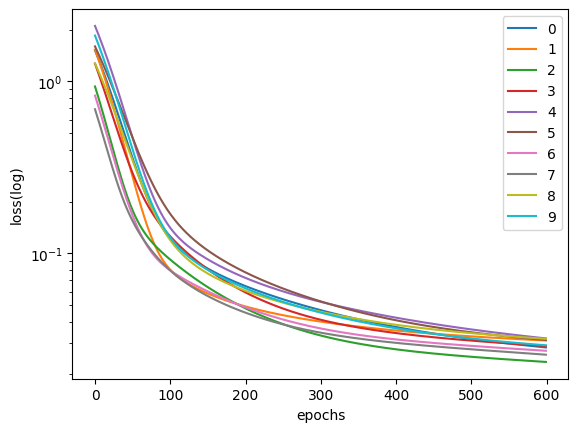

In [8]:
fig = plt.figure()
ax = fig.add_subplot()


# 学習曲線
# ax.plot(history.history["loss"], label = "train")
for i, H  in enumerate(save_history):
    H["loss"]
    # 活性化関数tanhで学習した後のtanh_test
    ax.plot(H["loss"], label = f"{i}")
    # ax.plot(H["val_loss"], label = "val_loss")

ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [9]:
max_save_loss = list()
min_save_loss = list()
max_save_val_loss = list()
min_save_val_loss = list()

max(save_loss), min(save_loss), max(save_val_loss), min(save_val_loss), np.average(save_loss), np.average(save_val_loss)


(0.04463426396250725,
 0.02336467243731022,
 0.112494558095932,
 0.02376248687505722,
 0.03058838061988354,
 0.05570859685540199)

In [10]:
model.evaluate(x_test, y_test, verbose = False)

0.06839665025472641

In [19]:
model = models.Sequential()
# model.add(layers.Input(shape=x_train.shape[1:]))
model.add(layers.LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1:], 1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
lstm_history = model.fit(x_train, y_train, batch_size=32, epochs=100)

TypeError: Dimension value must be integer or None or have an __index__ method, got value '(30,)' with type '<class 'tuple'>'